# Lagged cross-covariance analysis

Resolution: TransCom 3 regions, weekly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("grey")

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Compute the weekly mean in each Transcom region
DS_tc = utils.read_transcom("../data/exp_pro/TRANSCOM_region_mask.nc")

df_sif_tc = (
    utils.map_transcom(DS_sif, DS_tc)
    .groupby(["region"])
    .resample("1W")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)
df_xco2_tc = (
    utils.map_transcom(DS_xco2, DS_tc)
    .groupby(["region"])
    .resample("1W")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)

# Merge dataframes
df_tc_weekly = pd.merge(df_sif_tc, df_xco2_tc, on=["region", "time"], how="outer")
df_tc_weekly

,region,time,sif,xco2
0,1.0,2014-09-07,0.047184,391.506042
1,1.0,2014-09-14,0.101233,392.618103
2,1.0,2014-09-21,0.079697,393.998993
3,1.0,2014-09-28,0.052416,393.973114
4,1.0,2014-10-05,0.037867,394.243561
...,...,...,...,...
3394,11.0,2020-07-05,0.511245,411.023682
3395,11.0,2020-07-12,0.515835,410.270508
3396,11.0,2020-07-19,0.445724,409.005737
3397,11.0,2020-07-26,0.447708,407.978271


In [6]:
# Groupby region and compute cross-covariance
df_stats = (
    df_tc_weekly
    .drop(columns=["time"])
    .groupby(["region"])
    .apply(lambda group: stats.get_stats_df(group, lags=[4, 8]))
    .reset_index()
    .drop(columns=["level_1"])
 )

df_stats

,region,sif_count,xco2_count,sif_slope,xco2_slope,sif_std,xco2_std,xcor_lag4,xcor_lag8
0,1.0,257,251,0.000037,0.050990,0.070373,3.619908,-0.715401,-0.635110
1,2.0,296,296,0.000130,0.050474,0.149663,2.098093,-0.728693,-0.893417
2,3.0,296,296,-0.000010,0.048531,0.026600,1.138175,-0.417948,-0.303308
3,4.0,296,296,0.000050,0.047633,0.060994,0.697966,-0.244360,0.060668
4,5.0,300,300,0.000015,0.050425,0.036646,1.872192,-0.779675,-0.814793
5,6.0,299,299,0.000058,0.047081,0.091735,0.845500,-0.780256,-0.559070
6,7.0,299,295,0.000157,0.049572,0.124534,3.255894,-0.876700,-0.694807
7,8.0,301,301,0.000077,0.049983,0.043284,2.170186,-0.728771,-0.829511
8,9.0,300,300,0.000107,0.050051,0.090191,1.541223,-0.617378,-0.745731
9,10.0,299,299,-0.000064,0.048241,0.030651,0.480493,-0.483492,-0.165802


In [7]:
# Map values to transcom grid dataset
df_regions = DS_tc.to_dataframe().dropna().reset_index()
DS_regions = (
    df_regions
    .merge(df_stats, on=["region"])
    .set_index(["lon", "lat"])
    .to_xarray()
   )

DS_regions

<xarray.Dataset>
Dimensions:     (lat: 137, lon: 338)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -54.5 -53.5 -52.5 -51.5 ... 78.5 79.5 80.5 82.5
Data variables:
    region      (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    sif_count   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xco2_count  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_slope   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xco2_slope  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_std     (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xco2_std    (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag4   (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag8   (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan

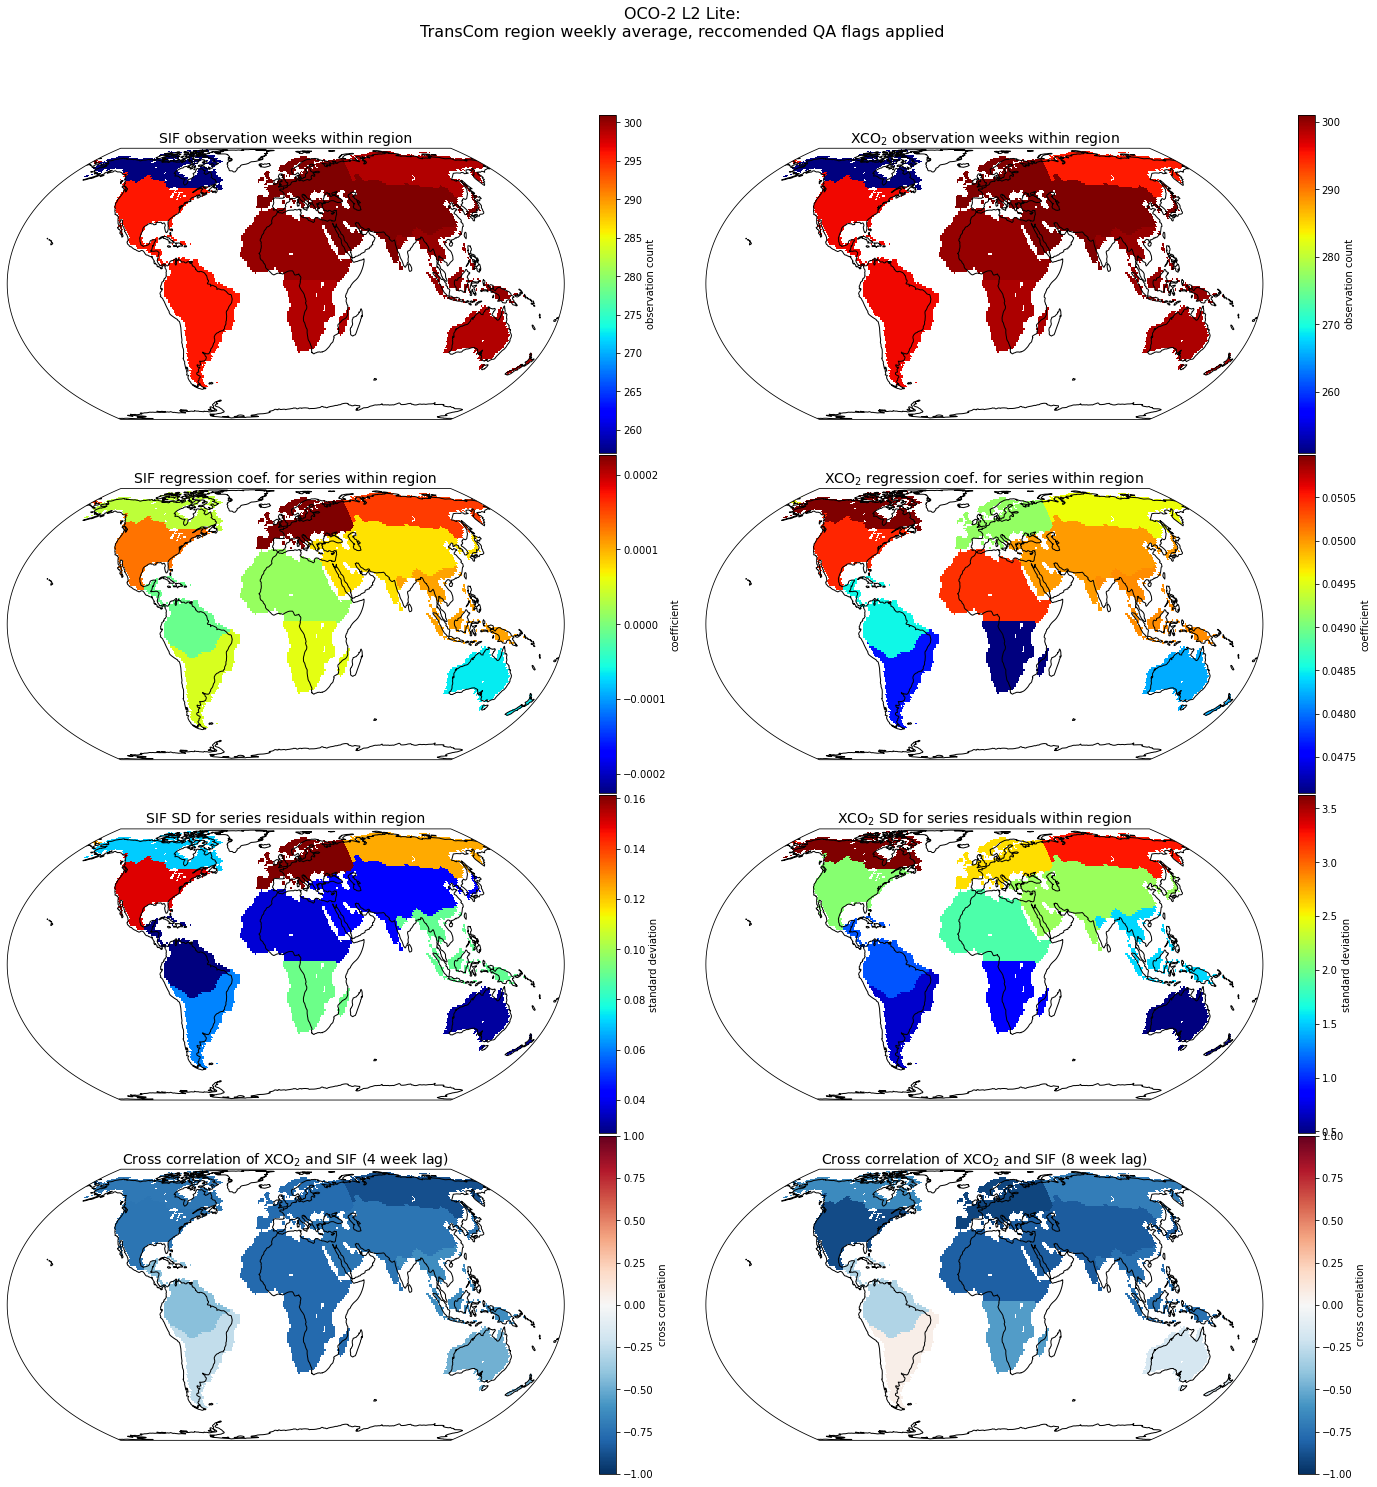

In [8]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "TransCom region weekly average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_count,
    title="SIF observation weeks within region",
    ax=ax1,
    cbar_kwargs={"label": "observation count"}
)
plot.plot_da(
    DS_regions.xco2_count,
    title="XCO$_2$ observation weeks within region",
    ax=ax2,
    cbar_kwargs={"label": "observation count"}
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_slope,
    title="SIF regression coef. for series within region",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_regions.xco2_slope,
    title="XCO$_2$ regression coef. for series within region",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_std,
    title="SIF SD for series residuals within region",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_regions.xco2_std,
    title="XCO$_2$ SD for series residuals within region",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.xcor_lag4,
    title="Cross correlation of XCO$_2$ and SIF (4 week lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_regions.xcor_lag8,
    title="Cross correlation of XCO$_2$ and SIF (8 week lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/transcom_weekly_panel.png");